In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


In [ ]:
seed=1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
batch_size = 64
learning_rate = 0.001

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
train_trans = transforms.Compose(
    [
     transforms.RandomResizedCrop((227,227)),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)
    ]
)

val_trans = transforms.Compose(
    [
     transforms.Resize((227,227)),
     transforms.CenterCrop((227, 227)),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)
    ]
)

In [ ]:
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/train',
                                 transform=train_trans,
                                 )

val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/val',
                                 transform=val_trans,
                                 )

test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/test',
                                 transform=val_trans,
                                 )

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False)

In [ ]:
class conv_block (nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                padding):
        super(conv_block, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self, X):

        out = self.relu(self.bn(self.conv(X)))

        return out

class Alexnet (nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Alexnet, self).__init__()

        self.conv1 = conv_block(in_channels=in_channels,
                      out_channels=96,
                      kernel_size=(11,11),
                      stride=(4,4),
                      padding=(0,0))

        self.pool = nn.MaxPool2d(kernel_size=(3,3),
                                 stride=(2,2),
                                 padding=(0,0))

        self.conv2 = conv_block(in_channels=96,
                                out_channels=256,
                                kernel_size=(5,5),
                                stride=(1,1),
                                padding=(2,2))

        self.conv3 = conv_block(in_channels=256,
                                out_channels=384,
                                kernel_size=(3,3),
                                stride=(1,1),
                                padding=(1,1))

        self.conv4 = conv_block(in_channels=384,
                                out_channels=384,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=(1, 1))

        self.conv5 = conv_block(in_channels=384,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=(1, 1))

        self.conv6 = conv_block(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=(1, 1))

        self.fc1 = nn.Linear(in_features=256*6*6,
                             out_features=4096)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self,X):

        out = self.conv1(X)
        out = self.pool(out)
        out = self.conv2(out)
        out = self.pool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.pool(out)

        out = out.view(out.size(0), 256*6*6)

        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out

In [ ]:
model = Alexnet(in_channels=3,
                 num_classes=2).to(device)
print(model)

Alexnet(
  (conv1): conv_block(
    (conv): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
  (conv2): conv_block(
    (conv): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv3): conv_block(
    (conv): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv4): conv_block(
    (conv): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv5): conv_block(
    (conv): Conv2d(

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def train_loop (model, num_epochs, step_lr_scheduler, loss_train, loss_val, train_acc_hist, val_acc_hist, best_acc):

  for epoch in range(num_epochs):

      model.train()

      running_loss = 0.0
      running_corrects = 0

      for idx, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)
          z_scores = model(images)
          loss = criterion(z_scores, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * images.size(0)
          _, predictions = torch.max(z_scores, 1)
          running_corrects += torch.sum(predictions == labels)

      epoch_loss = running_loss / len(train_dataset)
      epoch_acc = running_corrects / len(train_dataset)
      print(f'Epoch {epoch+1} / {num_epochs}, '
            f'Train Loss {epoch_loss:.4f}, '
            f'Train Acc {epoch_acc:.4f}')

      train_acc_hist.append(epoch_acc)
      loss_train.append(epoch_loss)

      step_lr_scheduler.step()

      model.eval()

      running_loss = 0.0
      running_corrects = 0

      for idx, (images, labels) in enumerate(val_loader):
          images = images.to(device)
          labels = labels.to(device)

          with torch.no_grad():
              z_scores = model(images)
              loss = criterion(z_scores, labels)

              running_loss += loss.item() * images.size(0)
              _, predictions = torch.max(z_scores, 1)
              running_corrects += torch.sum(predictions == labels)

      epoch_loss_val = running_loss / len(val_dataset)
      epoch_acc_val = running_corrects / len(val_dataset)
      print(f'Epoch {epoch + 1} / {num_epochs}, '
            f'Val Loss {epoch_loss_val:.4f}, '
            f'Val Acc {epoch_acc_val:.4f}')

      val_acc_hist.append(epoch_acc_val)
      loss_val.append(epoch_loss_val)

      if epoch_acc_val > best_acc:
          best_acc = epoch_acc_val

In [ ]:
def calculate_time (time_elapsed):
    minutes = time_elapsed // 60
    seconds = time_elapsed % 60
    if minutes > 60:
        hours = minutes // 60
        new_minutes = minutes % 60
        print(f'Training complete in {hours:.0f}h {new_minutes:.0f}m {seconds:.0f}s')
    else:
        print(f'Training complete in {minutes:.0f}m {seconds:.0f}s')

In [ ]:
num_epochs = 5
val_acc_hist = []
train_acc_hist = []
loss_train = []
loss_val = []
best_acc = 0.0

In [ ]:
start = time.time()
train_loop(model, num_epochs, step_lr_scheduler, loss_train, loss_val, train_acc_hist, val_acc_hist, best_acc)
time_elapsed = time.time() - start

Epoch 1 / 5, Train Loss 34.7461, Train Acc 0.4918
Epoch 1 / 5, Val Loss 33.5068, Val Acc 0.4301
Epoch 2 / 5, Train Loss 2.5391, Train Acc 0.5656
Epoch 2 / 5, Val Loss 0.9536, Val Acc 0.5699
Epoch 3 / 5, Train Loss 0.7818, Train Acc 0.5246
Epoch 3 / 5, Val Loss 2.1706, Val Acc 0.3441
Epoch 4 / 5, Train Loss 0.8330, Train Acc 0.5205
Epoch 4 / 5, Val Loss 0.6690, Val Acc 0.5484
Epoch 5 / 5, Train Loss 0.7264, Train Acc 0.5041
Epoch 5 / 5, Val Loss 0.6380, Val Acc 0.5699


In [ ]:
calculate_time(time_elapsed)

Training complete in 1m 53s


In [ ]:
print(f'Best validation Accuracy: {best_acc:.4f}')

Best validation Accuracy: 0.0000


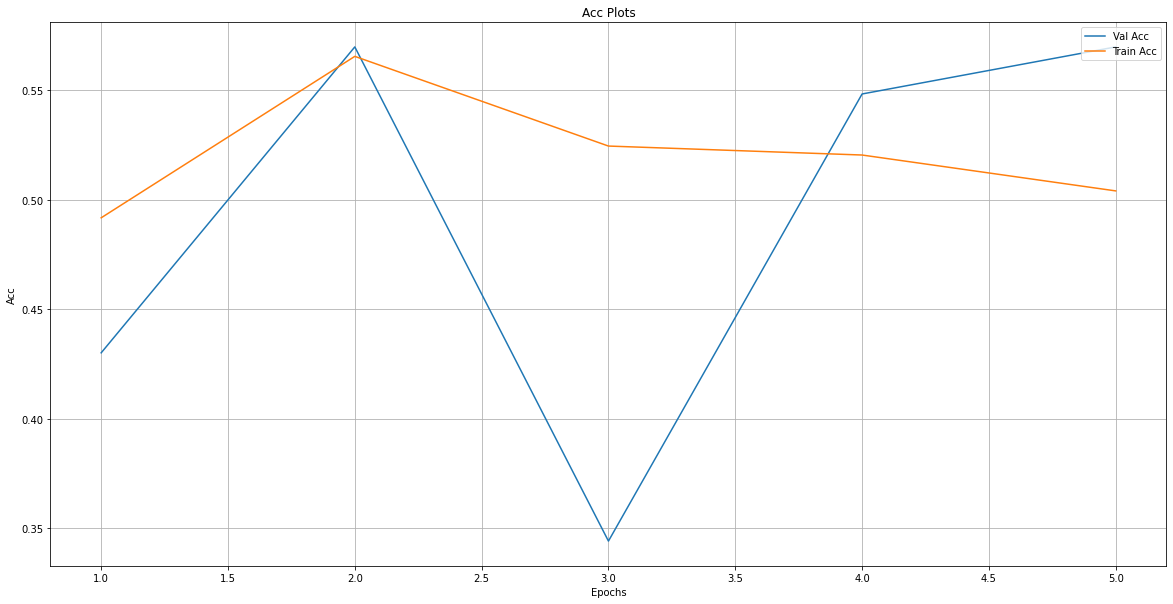

In [ ]:
val_acc_hist_numpy = [acc.cpu().numpy() for acc in val_acc_hist]
train_acc_hist_numpy = [acc.cpu().numpy() for acc in train_acc_hist]
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), val_acc_hist_numpy, label='Val Acc')
plt.plot(range(1, num_epochs+1), train_acc_hist_numpy, label='Train Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title("Acc Plots")
plt.legend(loc='upper right')
plt.show()

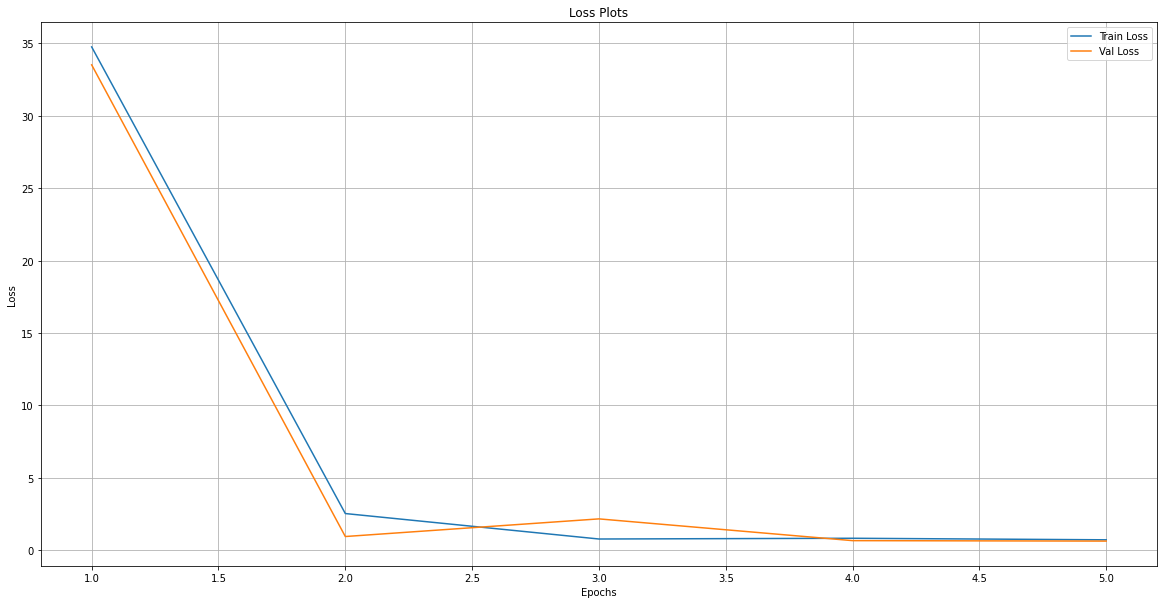

In [ ]:
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), loss_train, label='Train Loss')
plt.plot(range(1, num_epochs+1), loss_val, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [ ]:
model.eval()

running_corrects = 0

with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        z_scores = model(images)

        _, predictions = torch.max(z_scores,1)
        running_corrects += torch.sum(predictions == labels)

    acc = running_corrects / len(test_dataset)
    print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.5000


In [ ]:
checkpoint = {
                'model_state_dict': model.state_dict(),
                'model_optimizer': optimizer.state_dict(),
                'val_acc_hist': val_acc_hist,
                'train_acc_hist': train_acc_hist,
                'loss_train': loss_train,
                'loss_val': loss_val,
                'best_acc': best_acc
}

torch.save(checkpoint, '/content/drive/MyDrive/alexnet_on_hymeno.pth')